In [1]:
from tensorly.decomposition import non_negative_tucker
import tensorly as tl
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import itertools
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Reading in data

In [2]:
# this should be the main cells file provided with the manuscript
cells = pd.read_pickle('cells2_salil')
patient_to_group_dict = cells.loc[:,['patients','groups']].drop_duplicates().set_index('patients').to_dict()['groups']
group1_patients = [a for a,gp in patient_to_group_dict.items() if gp==1]
group2_patients = [a for a,gp in patient_to_group_dict.items() if gp==2]

In [22]:
cells['patients'] = cells['patients'].astype('category')
cells['neighborhood10'] = cells['neighborhood10'].astype('category')
cells['ClusterName'] = cells['ClusterName'].astype('category')

In [3]:
# select the cts
cts = ['CD11b+CD68+ macrophages',
 'tumor cells / immune cells',
 'adipocytes',
 'CD68+ macrophages',
 'immune cells / vasculature',
 'CD4+ T cells',
 'Tregs',
 'plasma cells',
 'vasculature',
 'B cells',
 'CD4+ T cells CD45RO+',
 'CD8+ T cells',
 'stroma',
 'granulocytes',
 'smooth muscle',
 'CD68+CD163+ macrophages',
 'tumor cells']

# select the cns
cns = [0,2,3,4,6,7,8,9]

# Build the tensors for each patient group

In [4]:
counts = cells.groupby(['patients','neighborhood10','ClusterName']).size()

In [5]:
#initialize the tensors
T1 = np.zeros((len(group1_patients),len(cns),len(cts)))
T2 = np.zeros((len(group2_patients),len(cns),len(cts)))


for i,pat in enumerate(group1_patients):
    for j,cn in enumerate(cns):
        for k,ct in enumerate(cts):
            T1[i,j,k] = counts.loc[(pat,cn,ct)]
            
for i,pat in enumerate(group2_patients):
    for j,cn in enumerate(cns):
        for k,ct in enumerate(cts):
            T2[i,j,k] = counts.loc[(pat,cn,ct)]

#normalize so we have joint distributions each slice
dat1 =np.nan_to_num(T1/T1.sum((1,2), keepdims = True))
dat2 =np.nan_to_num(T2/T2.sum((1,2), keepdims = True))

# The following tries different numbers of CN modules/CT modules to determine suitable rank for decomposition

In [70]:
def evaluate_ranks(dat, num_tissue_modules = 2):
    num_tissue_modules = num_tissue_modules+1
    pal = sns.color_palette('bright',10)
    palg = sns.color_palette('Greys',10)
    
    mat1 = np.zeros((num_tissue_modules,15))
    for i in range(2,15):
        for j in range(1,num_tissue_modules):
            # we use NNTD as described in the paper
            facs_overall = non_negative_tucker(dat,rank=[j,i,i],random_state = 2336)
            mat1[j,i] = np.mean((dat- tl.tucker_to_tensor((facs_overall[0],facs_overall[1])))**2)
    for j in range(1,num_tissue_modules):
        plt.plot(2+np.arange(13),mat1[j][2:],label = 'rank = ({},x,x)'.format(j))
        
    plt.xlabel('x')
    plt.ylabel('reconstruction error')
    plt.legend()
    plt.show()
    

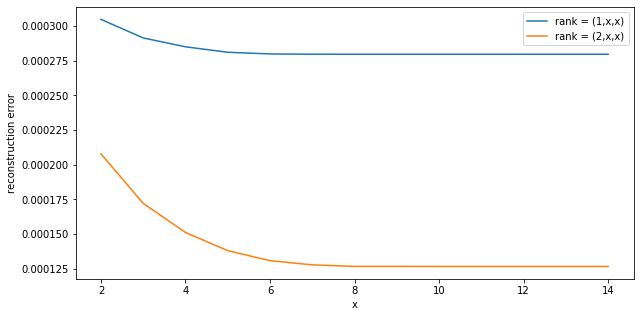

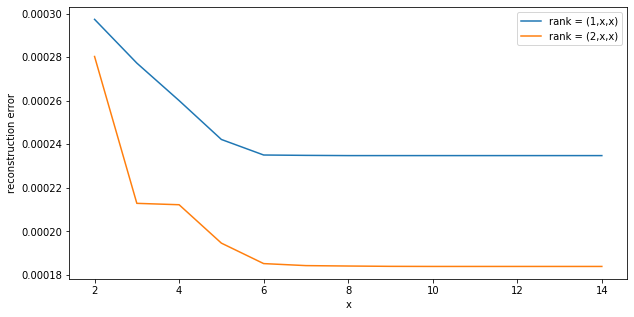

In [74]:
evaluate_ranks(dat1,2)
plt.show()
evaluate_ranks(dat2,2)
plt.show()

# The following visualizes the tensor decomposition output
- The exact sizing of the font and aesthetics is difficult to adjust for different sizes and will have to be optimized for number of cell types/cns and intended figure size for your paper.
- Therefore, I have also included a simpler/more conventional visualization of tensor decomposition (plot_modules_heatmap). Only if this analysis is interesting, is it worth proceeding to optimize the layout. 

In [173]:
def plot_modules_heatmap(dat,num_tissue_modules = 2, num_cn_modules = 6):
    figsize(20,5)
    core, factors = non_negative_tucker(dat,rank=[num_tissue_modules,num_cn_modules,num_cn_modules],random_state = 32)
    plt.subplot(1,2,1)
    sns.heatmap(pd.DataFrame(factors[1],index = cns))
    plt.ylabel('CN')
    plt.xlabel('CN module')
    plt.title('Loadings onto CN modules')
    plt.subplot(1,2,2)
    sns.heatmap(pd.DataFrame(factors[2],index = cts))
    plt.ylabel('CT')
    plt.xlabel('CT module')
    plt.title('Loadings onto CT modules')
    plt.show()
    
    figsize(num_tissue_modules*3,3)
    for p in range(num_tissue_modules):
        plt.subplot(1, num_tissue_modules, p+1)
        sns.heatmap(pd.DataFrame(core[p]))
        plt.title('tissue module {}, couplings'.format(p))
        plt.ylabel('CN module')
        plt.ylabel('CT module')
    plt.show()

    
        
    

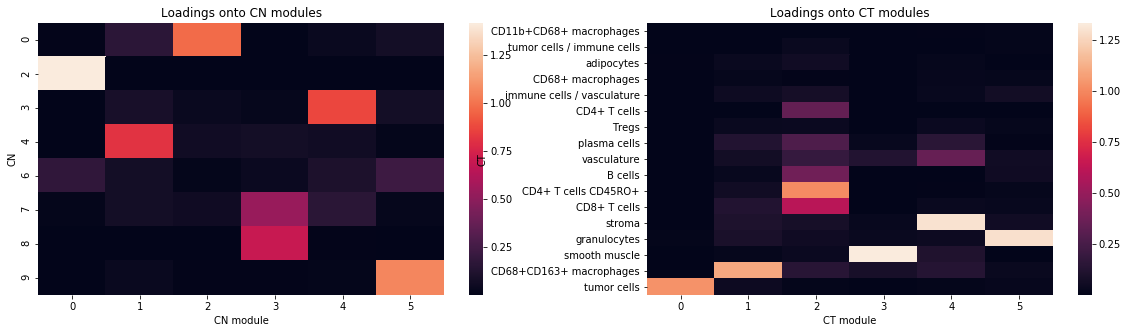

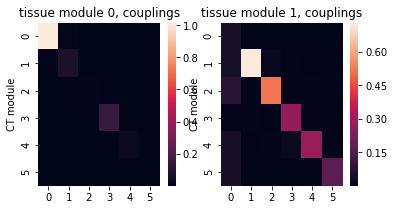

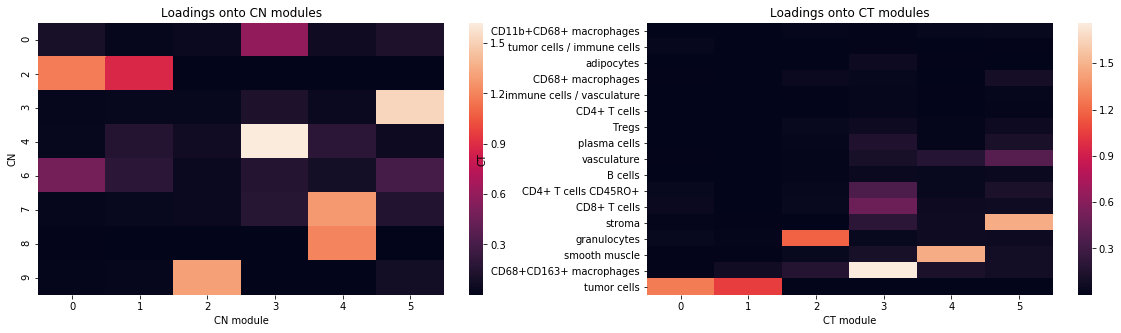

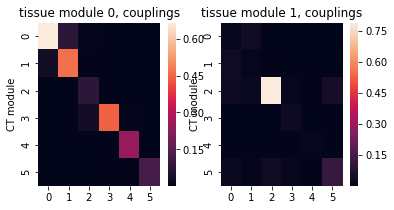

In [175]:
plot_modules_heatmap(dat1)
plot_modules_heatmap(dat2)

In [118]:
def plot_modules_graphical(dat,num_tissue_modules = 2, num_cn_modules = 6, scale = 0.4):
    core, factors = non_negative_tucker(dat,rank=[num_tissue_modules,num_cn_modules,num_cn_modules],random_state = 32)
    

    pal = sns.color_palette('bright',10)
    palg = sns.color_palette('Greys',10)
    
    figsize(3.67*scale,2.00*scale)
    cn_scatter_size = scale*scale*45
    cel_scatter_size = scale*scale*15
    
    

    for p in range(num_tissue_modules):
        for idx in range(num_cn_modules):
            an = float(np.max(core[p][idx,:])>0.1) + (np.max(core[p][idx,:])<=0.1)*0.05
            ac = float(np.max(core[p][:,idx])>0.1) + (np.max(core[p][:,idx])<=0.1)*0.05

            cn_fac = factors[1][:,idx]
            cel_fac = factors[2][:,idx]

            cols_alpha = [(*pal[cn], an*np.minimum(cn_fac, 1.0)[i]) for i,cn in enumerate(cns)]
            cols = [(*pal[cn], np.minimum(cn_fac, 1.0)[i]) for i,cn in enumerate(cns)]
            cell_cols_alpha = [(0,0,0, an*np.minimum(cel_fac, 1.0)[i]) for i,_ in enumerate(cel_fac)]
            cell_cols = [(0,0,0, np.minimum(cel_fac, 1.0)[i]) for i,_ in enumerate(cel_fac)]
            
            plt.scatter(0.5*np.arange(len(cn_fac)), 5*idx + np.zeros(len(cn_fac)), c = cols_alpha, s = cn_scatter_size)
            offset = 9
            for i,k in enumerate(cns):
                plt.text(0.5*i, 5*idx, k,fontsize = scale*2,ha = 'center', va = 'center',alpha = an)

            plt.scatter(-4.2+0.25*np.arange(len(cel_fac))+offset, 5*idx + np.zeros(len(cel_fac)), c = cell_cols_alpha, s = 0.5*cel_scatter_size)#,vmax = 0.5,edgecolors=len(cell_cols_alpha)*[(0,0,0,min(1.0,max(0.1,2*an)))], linewidths= 0.05)
            
            
            rect = plt.Rectangle((-0.5,5*idx-2 ),4.5,4,linewidth=scale*scale*1,edgecolor='black',facecolor='none',zorder = 0,alpha = an,linestyle = '--')
            ax = plt.gca()
            ax.add_artist(rect)
            plt.scatter([offset-5],[5*idx],c = 'black', marker = 'D', s = scale*scale*5, zorder = 5,alpha = an)
            plt.text(offset-5,5*idx,idx,color = 'white',alpha = an, ha = 'center', va = 'center',zorder = 6,fontsize = 4.5)
            plt.scatter([offset-4.5],[5*idx],c = 'black', marker = 'D', s = scale*scale*5, zorder = 5,alpha = ac)
            plt.text(offset-4.5,5*idx,idx,color = 'white',alpha = ac, ha = 'center', va = 'center', zorder = 6,fontsize = 4.5)

            rect = plt.Rectangle((offset-4.5,5*idx-2 ),4.5,4,linewidth=scale*1,edgecolor='black',facecolor='none',zorder = 0, alpha = ac,linestyle = '-.')
            ax.add_artist(rect)

        for i,ct in enumerate(cts):
                plt.text(-4.2+offset+0.25*i, 27.5, ct, rotation = 45, color = 'black',ha = 'left', va = 'bottom',fontsize = scale*2,alpha = 1)
        for cn_i in range(num_cn_modules):
            for cel_i in range(num_cn_modules):
                plt.plot([-3+offset -2, -4+offset - 0.5],[5*cn_i, 5*cel_i], color = 'black', linewidth =2*scale*scale*1* min(1.0, max(0,-0.00+core[p][cn_i,cel_i])),alpha = min(1.0, max(0.000,-0.00+10*core[p][cn_i,cel_i])))#max(an,ac))



        plt.ylim(-5, 30)
        plt.axis('off')
        

        plt.show()

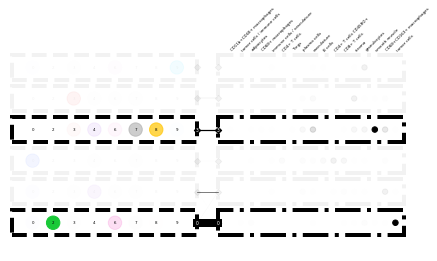

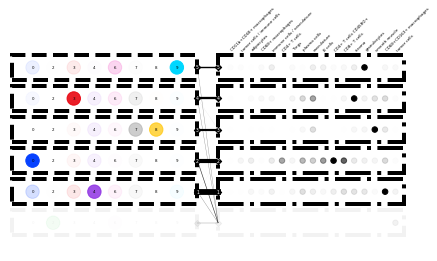

In [119]:
plot_modules(dat1,scale  = 2)

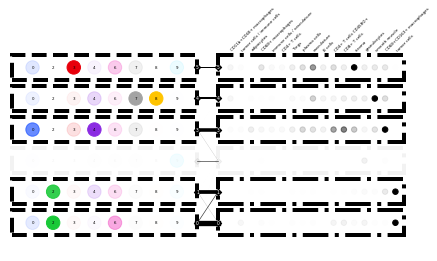

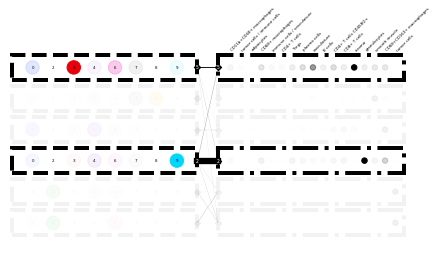

In [176]:
plot_modules(dat2,scale  = 2)